### Statistical inference


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative
import pandas as pd
from scipy.integrate import quad

In [4]:
plt.style.use('cyberpunk')

In [5]:
cov=pd.read_csv('pantheon+_sys_full_long.txt').to_numpy()
cov


array([[0.03177108],
       [0.00575443],
       [0.00031006],
       ...,
       [0.00588703],
       [0.00875111],
       [0.04499005]])

In [6]:
cov.reshape((1701,1701))

array([[ 3.177108e-02,  5.754430e-03,  3.100600e-04, ...,  2.945500e-04,
        -8.595000e-05, -2.701100e-04],
       [ 5.754430e-03,  3.456656e-02,  6.595500e-04, ..., -2.863200e-04,
        -2.456300e-04, -2.363400e-04],
       [ 3.100600e-04,  6.595500e-04,  6.125745e-02, ...,  1.936450e-03,
         3.214810e-03,  4.000510e-03],
       ...,
       [ 2.945500e-04, -2.863200e-04,  1.936450e-03, ...,  4.157373e-02,
         4.902260e-03,  5.887030e-03],
       [-8.595000e-05, -2.456300e-04,  3.214810e-03, ...,  4.902260e-03,
         6.742823e-02,  8.751110e-03],
       [-2.701100e-04, -2.363400e-04,  4.000510e-03, ...,  5.887030e-03,
         8.751110e-03,  4.499005e-02]])

In [7]:
shoes=pd.read_csv('pantheon+_lcparam_full_long_zhel.txt', delimiter=' ')
shoes

,CID,zHD,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,0.00122,0.00082,0.00002,9.74571,1.516210,28.9987,1.516450,29.1770,1,...,0.1071,36,26.88590,0.864470,0.0991,1.4960,0.0381,0.005,1.000,0.003
1,2011fe,0.00122,0.00082,0.00002,9.80286,1.517230,29.0559,1.517470,29.1770,1,...,0.0579,101,88.30640,0.812220,0.0971,1.4960,-0.0252,0.003,1.000,0.004
2,2012cg,0.00256,0.00144,0.00002,11.47030,0.781906,30.7233,0.782372,30.8433,1,...,0.0278,165,233.50000,0.000358,0.0399,0.7134,0.0545,0.019,1.000,0.036
3,2012cg,0.00256,0.00144,0.00002,11.49190,0.798612,30.7449,0.799068,30.8433,1,...,0.0667,55,100.12200,0.000193,0.0931,0.7134,0.0622,0.028,1.000,0.040
4,1994DRichmond,0.00299,0.00187,0.00004,11.52270,0.880798,30.7757,0.881212,-9.0000,0,...,0.0522,146,109.83900,0.988740,0.0567,0.6110,0.0650,0.009,1.000,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,rutledge,1.61505,1.61399,0.00500,25.90650,0.331927,45.1595,0.333024,-9.0000,0,...,1.7256,8,2.92493,0.938980,0.2230,0.0106,-0.0203,0.005,1.000,0.002
1697,geta,1.69706,1.70000,0.04000,26.03330,0.379521,45.2863,0.380480,-9.0000,0,...,1.8973,12,9.15387,0.689730,0.3209,0.0748,0.2680,0.005,0.633,0.000
1698,stone,1.80119,1.80000,0.02000,26.23350,0.280685,45.4865,0.281981,-9.0000,0,...,1.1631,11,11.69320,0.387140,0.2370,0.0358,-0.0968,0.004,0.641,0.000
1699,wilson,1.91165,1.91401,0.00100,26.17030,0.357624,45.4233,0.358642,-9.0000,0,...,1.4902,9,5.54378,0.784570,0.3168,0.0044,-0.3835,0.013,0.604,0.000


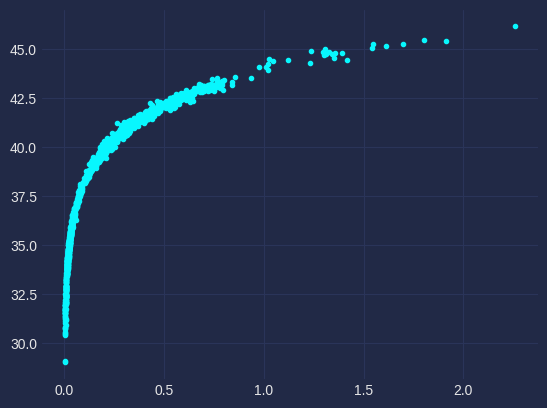

In [9]:
redshift=shoes['zHD']
mu=shoes['MU_SH0ES']

plt.plot(redshift, mu,'.')

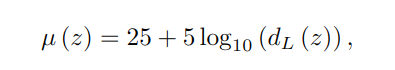

In [10]:
#importing model
nodos=20
ANN_Dl =  nn.Sequential(nn.Linear(3, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))

ANN_Dl.load_state_dict(torch.load('CPL_param_dict_50'))
ANN_Dl.eval()

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=1, bias=True)
)

In [11]:
ANN_Dl(torch.tensor([0.1,0.1,0.1]))

tensor([0.9716], grad_fn=<ViewBackward0>)

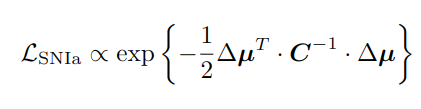

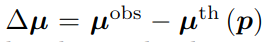

In [12]:
#DL numérica
Omega_m0 = 0.3
Omega_Lambda0 = 0.7
omega_0, omega_a = 1,1

zi=0.0
#zf=3.0

def integrand(z, omega_0, omega_a):
    return 1 / np.sqrt(Omega_m0 * (1 + z)**3 + Omega_Lambda0 * (1 + z)**(3 * (1 + omega_0 + omega_a)) * np.exp(-3 * omega_a * z / (1 + z)))

def DL(omega_0, omega_a):
    resultado, _ =  quad(integrand, zi, zf,args=(omega_0, omega_a))
    return resultado  

In [13]:
redshift

0       0.00122
1       0.00122
2       0.00256
3       0.00256
4       0.00299
         ...   
1696    1.61505
1697    1.69706
1698    1.80119
1699    1.91165
1700    2.26137
Name: zHD, Length: 1701, dtype: float64

In [1]:
%timeit DL([12])

NameError: name 'DL' is not defined

In [ ]:
%timeit ANN_Dl(torch.tensor([0.0,1.0,1.0]))

134 µs ± 3.45 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
